In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from calculate_scores import *
import matplotlib.path as mpath
import matplotlib.patches as mpatches
# Visualize the result
import matplotlib
import matplotlib.lines as mlines
from skimage import measure
# Import required libraries
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
matplotlib.rcParams.update({'font.size': 16})
import functions
importlib.reload(functions)
from functions import * 



# Visualize the result
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


#bands = [6, 7, 20, 28, 28, 31]
bands=[29]
#bands=[1]
max_vals = np.load("/uio/hume/student-u37/fslippe/data/models/patch_size128/max_val_dnb_l95_z50_ps128_band29_2018-2023.npy")
min_vals = np.load("/uio/hume/student-u37/fslippe/data/models/patch_size128/min_val_dnb_l95_z50_ps128_band29_2018-2023.npy")
merra_folder = "/uio/hume/student-u37/fslippe/MERRA/"

1 Physical GPUs, 1 Logical GPUs
total cores: 256
1 Physical GPUs, 1 Logical GPUs


2024-05-12 13:44:01.089044: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2024-05-12 13:44:01.089277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 224 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [2]:
cao_threshold = 5 
patch_threshold = 0

last_filter = 128 
nK = 13
if cao_threshold >= 30:
    dict_list = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16.npy", allow_pickle=True)
else:
    years = [2019, 2020, 2021, 2022, 2023] 
    combined_dict_list = []
    for year in years:#/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16.npy
        filename =  f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_{year}.npy" 
        try:
            filename_2 = f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_{year}_1.npy" 
            print(filename_2)
            dict_list = np.load(filename, allow_pickle=True) 
            dict_list_2 = np.load(filename_2, allow_pickle=True) 
            combined_dict_list.extend([dict_list, dict_list_2]) 
        except:
            print("FAILED")
            dict_list = np.load(filename, allow_pickle=True)
            combined_dict_list.append(dict_list)

    dict_list = np.concatenate(combined_dict_list) 
        
    # dict_list_2019 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2019.npy", allow_pickle=True)
    # dict_list_2020 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2020.npy", allow_pickle=True)
    # dict_list_2021 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2021.npy", allow_pickle=True)
    # dict_list_2022 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2022.npy", allow_pickle=True)
    # dict_list_2023 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2023.npy", allow_pickle=True)
    # try:
    #     dict_list_2019_2 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2019_1.npy", allow_pickle=True)
    #     dict_list_2020_2 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2020_1.npy", allow_pickle=True)
    #     dict_list_2021_2 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2021_1.npy", allow_pickle=True)
    #     dict_list_2022_2 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2022_1.npy", allow_pickle=True)
    #     dict_list_2023_2 = np.load(f"/uio/hume/student-u37/fslippe/data/model_pred_info/filter{last_filter}/dict_filter{last_filter}_nK{nK}_caothr{cao_threshold}_sizethr_{patch_threshold}_stride16_year2023_1.npy", allow_pickle=True)
    #     combined_dict_list = np.concatenate((dict_list_2019, dict_list_2019_2, dict_list_2020, dict_list_2020_2, dict_list_2021, dict_list_2021_2, dict_list_2022, dict_list_2022_2, dict_list_2023, dict_list_2023_2))

    # except:
    #     combined_dict_list = np.concatenate((dict_list_2019, dict_list_2020, dict_list_2021, dict_list_2022, dict_list_2023))
    
dates = []
for year in [2019, 2020, 2021, 2022, 2023]:
    start = f"{year}0101"
    end = f"{year}0430"
    dates.extend(generate_date_list(start, end))
    start = f"{year}1001"
    end = f"{year}1231"
    dates.extend(generate_date_list(start, end))

print(len(dict_list))
    
dates_period = dates
dict_list

/uio/hume/student-u37/fslippe/data/model_pred_info/filter128/dict_filter128_nK13_caothr5_sizethr_0_stride16_2019_1.npy
/uio/hume/student-u37/fslippe/data/model_pred_info/filter128/dict_filter128_nK13_caothr5_sizethr_0_stride16_2020_1.npy
/uio/hume/student-u37/fslippe/data/model_pred_info/filter128/dict_filter128_nK13_caothr5_sizethr_0_stride16_2021_1.npy
/uio/hume/student-u37/fslippe/data/model_pred_info/filter128/dict_filter128_nK13_caothr5_sizethr_0_stride16_2022_1.npy
/uio/hume/student-u37/fslippe/data/model_pred_info/filter128/dict_filter128_nK13_caothr5_sizethr_0_stride16_2023_1.npy
1656


array([{'date': '20190101', 'date_day': '2019001', 'datetime': '2019-01-01T09:10', 'idx_closed': array([[ 27, 114],
              [ 30, 110],
              [ 24, 106],
              [ 26, 103],
              [ 25, 105],
              [ 30, 119],
              [ 33, 118],
              [ 35, 115],
              [ 39, 115],
              [ 38, 117],
              [ 22, 108],
              [ 21, 110],
              [ 26, 124],
              [ 29, 123],
              [ 23, 107],
              [ 27, 116],
              [ 28, 115],
              [ 33, 111],
              [ 35, 108],
              [ 24, 108],
              [ 25, 107],
              [ 33, 120],
              [ 25, 116],
              [ 38, 110],
              [ 31, 104],
              [ 39, 117],
              [ 26, 117],
              [ 40, 116],
              [ 29, 116],
              [ 21, 112],
              [ 26, 126],
              [ 29, 125],
              [ 36, 112],
              [ 30, 105],
              [ 24, 101],


In [3]:
patch_size = 128
times_folder = f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cao_date_time_lists/n_K_{nK}/"
dates_cao = []
times_cao = []
for yr in years:
    time_dict = np.load(times_folder + f"times_patch_size{patch_size}_filter{last_filter}_nK{nK}_thr{cao_threshold}_{yr}.npy", allow_pickle=True).item()
    half_step = len(time_dict["dates"]) // 2

    dates_cao.extend(time_dict["dates"][:])
    times_cao.extend(time_dict["times"][:])


In [4]:
from collections import Counter

dates = [item["date"] for item in dict_list]
date_counts = Counter(dates)
total_dates = sum(date_counts.values())
unique_dates = len(date_counts)
average_occurrences = total_dates / unique_dates
print(f"Average number of occurrences per date: {average_occurrences}")


Average number of occurrences per date: 3.4214876033057853


In [5]:
lon = xr.open_dataset(f"{merra_folder}2020/MERRA2_400.tavg1_2d_slv_Nx.20200312.SUB.nc").lon.values
lat = xr.open_dataset(f"{merra_folder}2020/MERRA2_400.tavg1_2d_slv_Nx.20200312.SUB.nc").lat.values
time_3h = xr.open_dataset(f"{merra_folder}2020/MERRA2_400.tavg1_2d_slv_Nx.20200312.SUB.nc").time.values
time_1h = xr.open_dataset(f"{merra_folder}2020/MERRA2_400.tavg1_2d_slv_Nx.20200312.SUB.nc").time.values
lon_mesh, lat_mesh = np.meshgrid(lon, lat)


In [6]:
projection = ccrs.Stereographic(central_latitude=90)
# x_grid, y_grid = generate_xy_grid(grid_resolution=128e3)
# x_grid_fram, y_grid_fram = generate_xy_grid(grid_resolution=64e3)
x_grid, y_grid = lon_mesh[:, :], lat_mesh[:, :]
x_grid_fram, y_grid_fram = lon_mesh[:, :], lat_mesh[:, :]



tree = cKDTree(list(zip(x_grid.ravel(), y_grid.ravel())))
tree_fram = cKDTree(list(zip(x_grid_fram.ravel(), y_grid_fram.ravel())))



In [7]:
dates_counted = {}
dates_counted_fram = {}
counts = np.zeros_like(x_grid)
counts_fram = np.zeros_like(x_grid)

for i in range(len(dict_list)):
# for i in range(1):
    date = dict_list[i]["date"]
    # if closed_idx.ndim == 2:

    if dict_list[i]["idx_closed"].ndim == 2:
        cord_x = dict_list[i]["idx_closed"][:,0]
        cord_y = dict_list[i]["idx_closed"][:,1]
        
    # if open_idx.ndim == 2:
    if dict_list[i]["idx_open"].ndim == 2:
        cord_x = np.append(cord_x, dict_list[i]["idx_open"][:,0])
        cord_y = np.append(cord_y, dict_list[i]["idx_open"][:,1])
    lat_i = lat_mesh[cord_x, cord_y]
    lon_i = lon_mesh[cord_x, cord_y]

    # x_proj, y_proj = projection.transform_points(ccrs.PlateCarree(),lon_i.ravel(),
    #                 lat_i.ravel())[:, :2].T

    idx_tot = np.where((lon_i <= 10) & (lon_i >= -10) & (lat_i > 75) & (lat_i < 80))


    _, idxs = tree.query(list(zip(lon_i.ravel(), lat_i.ravel())))
    
    x_proj_fram, y_proj_fram = lon_i[idx_tot].ravel(), lat_i[idx_tot].ravel()
    if len(x_proj_fram) > 1:
        _, idxs_fram = tree_fram.query(list(zip(x_proj_fram, y_proj_fram)))
        for idx in idxs_fram:
            if idx not in dates_counted_fram:
                dates_counted_fram[idx] = set()
            if date not in dates_counted_fram[idx]:
                counts_fram.ravel()[idx] += 1
                dates_counted_fram[idx].add(date)

    for idx in idxs:
        # counts.ravel()[idx] += 1
        if idx not in dates_counted:
            dates_counted[idx] = set()
        if date not in dates_counted[idx]:
            counts.ravel()[idx] += 1
            dates_counted[idx].add(date)
            

In [8]:
dates_counted_open = {}
dates_counted_closed = {}

counts_open = np.zeros_like(x_grid)
counts_closed = np.zeros_like(x_grid)
tree = cKDTree(list(zip(x_grid.ravel(), y_grid.ravel())))


for i in range(len(dict_list)):
# for i in range(1):
    date = dict_list[i]["date"]
        
    # if open_idx.ndim == 2:
    
    if dict_list[i]["idx_open"].ndim == 2:
        cord_x = dict_list[i]["idx_open"][:,0]

        cord_y = dict_list[i]["idx_open"][:,1]
        lat_i = lat_mesh[cord_x, cord_y]
        lon_i = lon_mesh[cord_x, cord_y]

        _, idxs = tree.query(list(zip(lon_i.ravel(), lat_i.ravel())))
    

        for idx in idxs:
            # counts.ravel()[idx] += 1
            if idx not in dates_counted_open:
                dates_counted_open[idx] = set()
            if date not in dates_counted_open[idx]:
                counts_open.ravel()[idx] += 1
                dates_counted_open[idx].add(date)

tree = cKDTree(list(zip(x_grid.ravel(), y_grid.ravel())))

for i in range(len(dict_list)):
# for i in range(1):
    date = dict_list[i]["date"]
        
    # if open_idx.ndim == 2:
    if dict_list[i]["idx_closed"].ndim == 2:
        cord_x = dict_list[i]["idx_closed"][:,0]

        cord_y = dict_list[i]["idx_closed"][:,1]
        lat_i = lat_mesh[cord_x, cord_y]
        lon_i = lon_mesh[cord_x, cord_y]

        _, idxs = tree.query(list(zip(lon_i.ravel(), lat_i.ravel())))
    

        for idx in idxs:
            # counts.ravel()[idx] += 1
            if idx not in dates_counted_closed:
                dates_counted_closed[idx] = set()
            if date not in dates_counted_closed[idx]:
                counts_closed.ravel()[idx] += 1
                dates_counted_closed[idx].add(date)
            

11 150
12 305
1 460
2 601
3 756
4 906


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


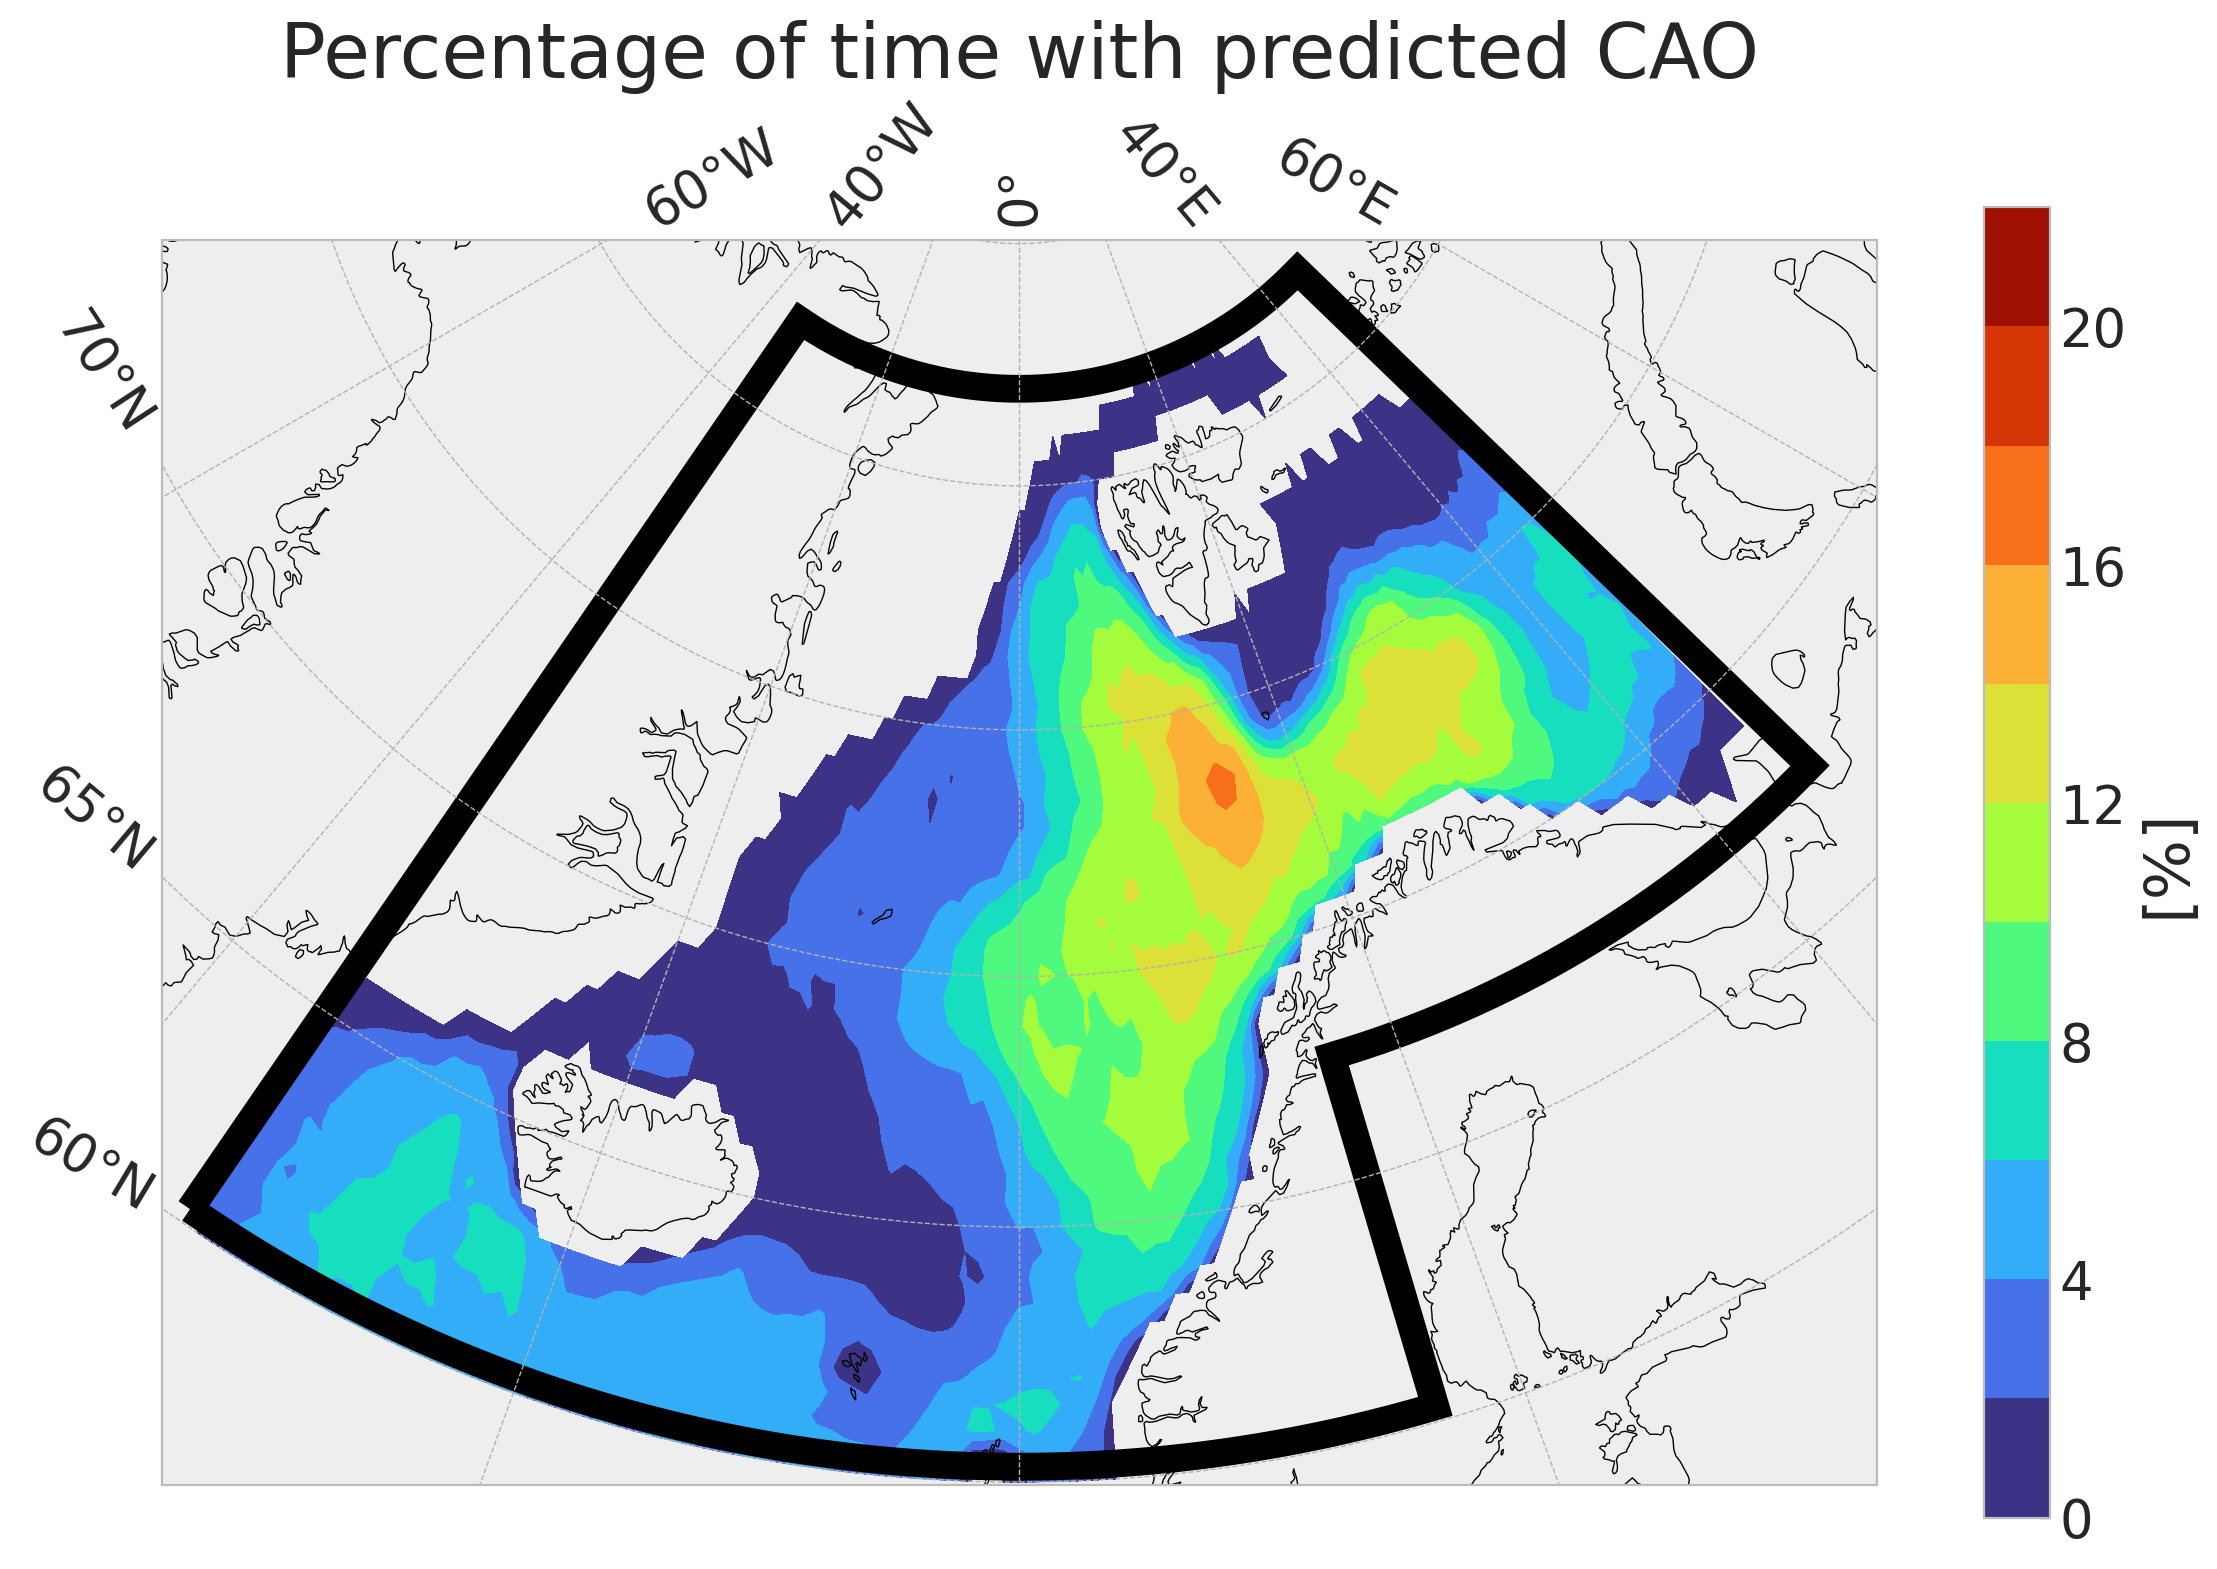

In [10]:
months = [11, 12, 1, 2, 3, 4]
c = 0
n_days = 0
levels = np.arange(0, 24, 2)
for month in months:
    chosen_month_str = str(month).zfill(2)

    formatted_dates_period = [datetime.datetime.strptime(date, '%Y%j').strftime('%Y%m%d') for date in dates_period]

    # Count the number of dates that fall within the chosen month
    n_days += sum(date[4:].startswith(f'{chosen_month_str}') for date in formatted_dates_period)
    print(month, n_days)


fig, ax = plot_hist_map(x_grid, y_grid, counts_open, n_days, projection, title="Percentage of time with predicted CAO", extent=[-35, 35, 59.7, 84], levels=levels, cmap="turbo")
save_folder = f"/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr{cao_threshold}/"

# fig.savefig(save_folder + f"hist_map_2019-2023_thr{cao_threshold}_pthr{patch_threshold}_{calendar.month_abbr[months[0]]}-{calendar.month_abbr[months[-1]]}.jpg")

In [10]:
chosen_month = 2  # The chosen month (e.g., January)

# Convert the chosen month to a string with leading zero if necessary
chosen_month_str = str(chosen_month).zfill(2)
formatted_dates_period = [datetime.datetime.strptime(date, '%Y%j').strftime('%Y%m%d') for date in dates_period]

# Count the number of dates that fall within the chosen month
num_days = sum(date[4:].startswith(f'{chosen_month_str}') for date in formatted_dates_period)

print(f"The number of days in month {chosen_month} is: {num_days}")

The number of days in month 2 is: 141


11 150
12 305
1 460
2 601
3 756
4 906


/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/uio/hume/student-u37/fslippe/.local/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


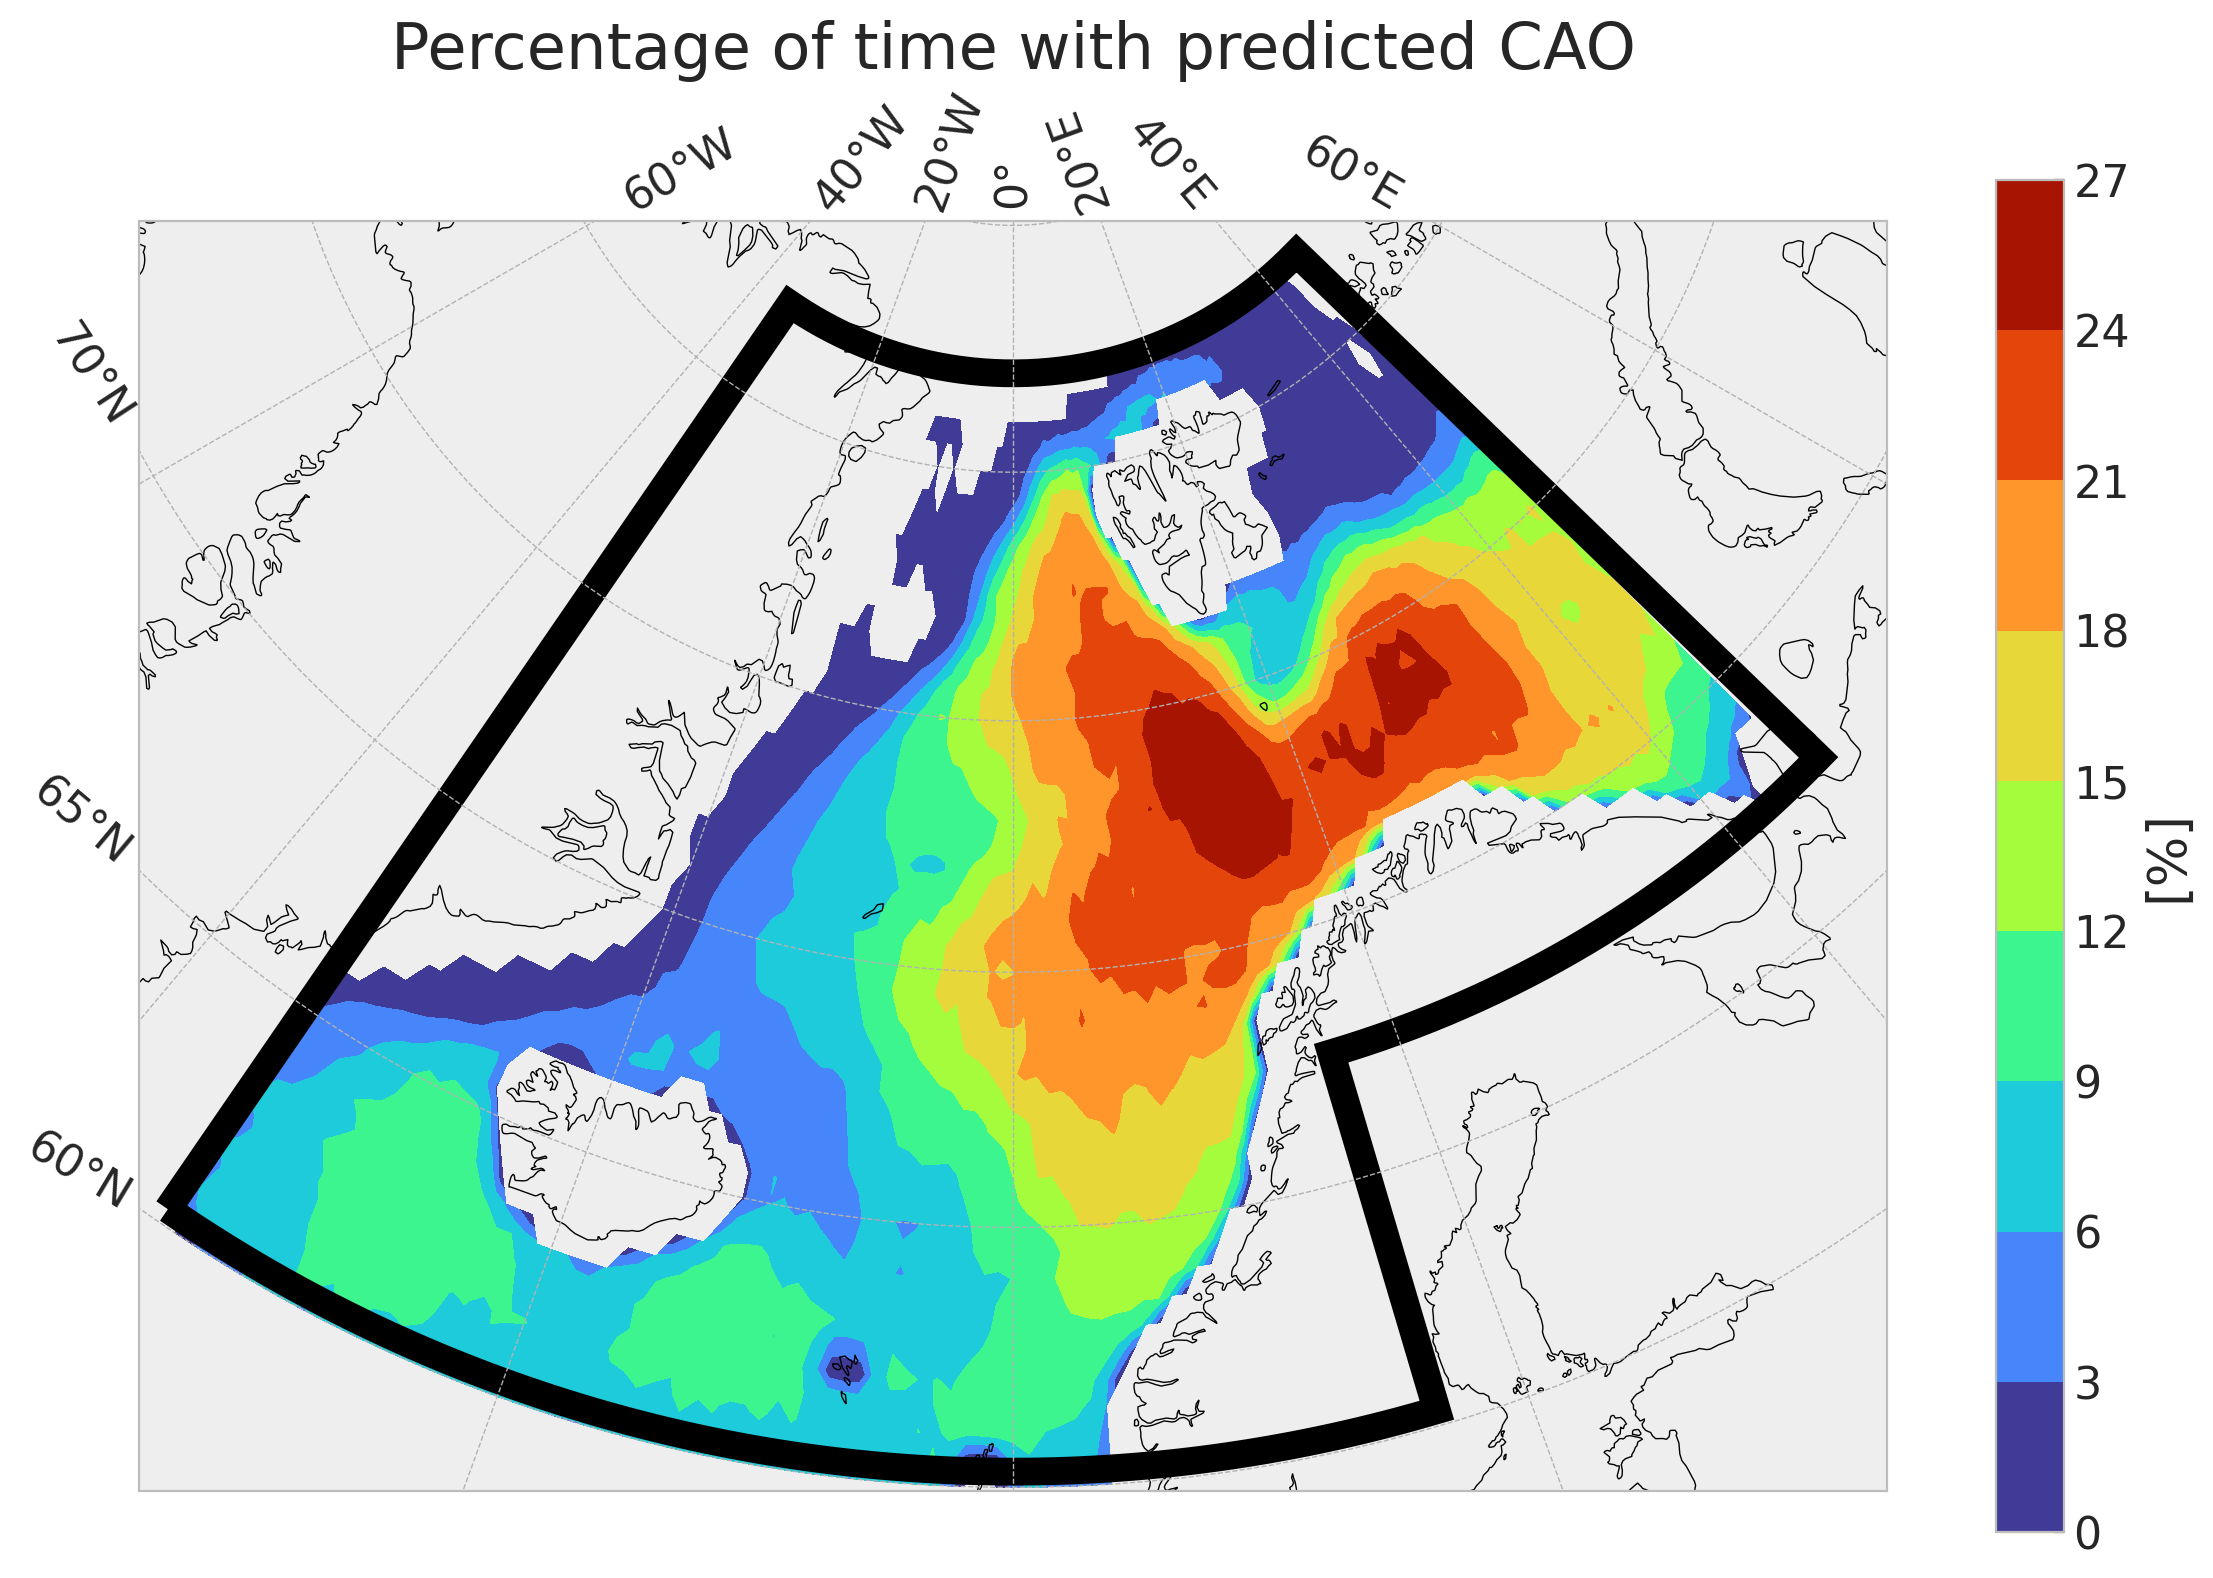

In [11]:
import plot_functions 
importlib.reload(plot_functions)
from plot_functions import * 
matplotlib.rcParams.update({'font.size': 16})

c = 0 
n_days = 0
months = [11, 12, 1, 2, 3, 4]
title="Percentage of time with predicted CAO"
extent=[-35, 35, 59.7, 84]
levels = np.arange(0, 30, 3)
cmap="turbo"
lon_min, lon_max = -35, 45
lat_min, lat_max = 60, 82

def get_hist_counts_month(month):
    dates_counted = {}
    dates_counted_fram = {}
    counts = np.zeros_like(x_grid)
    counts_fram = np.zeros_like(x_grid_fram)

    for i in range(len(dict_list)):
    # for i in range(1):
        date = dict_list[i]["date"]
        dtime_str = dict_list[i]["datetime"]
        dtime = datetime.datetime.strptime(dtime_str, '%Y-%m-%dT%H:%M')

        if dtime.month == month:
            if dict_list[i]["idx_closed"].ndim == 2:
                cord_x = dict_list[i]["idx_closed"][:,0]
                cord_y = dict_list[i]["idx_closed"][:,1]

            if dict_list[i]["idx_open"].ndim == 2:
                cord_x = np.append(cord_x, dict_list[i]["idx_open"][:,0])
                cord_y = np.append(cord_y, dict_list[i]["idx_open"][:,1])

            lat_i = lat_mesh[cord_x, cord_y]
            lon_i = lon_mesh[cord_x, cord_y]

            x_proj, y_proj = lon_i.ravel(), lat_i.ravel()

            idx_tot = np.where((lon_i < 15) & (lon_i > -15) & (lat_i > 76) & (lat_i < 81))


            _, idxs = tree.query(list(zip(x_proj, y_proj)))
            
            x_proj_fram, y_proj_fram = x_proj[idx_tot], y_proj[idx_tot]
            if len(x_proj_fram) > 1:
                _, idxs_fram = tree_fram.query(list(zip(x_proj_fram, y_proj_fram)))
                for idx in idxs_fram:
                    if idx not in dates_counted_fram:
                        dates_counted_fram[idx] = set()
                    if date not in dates_counted_fram[idx]:
                        counts_fram.ravel()[idx] += 1
                        dates_counted_fram[idx].add(date)

            for idx in idxs:
                # counts.ravel()[idx] += 1
                if idx not in dates_counted:
                    dates_counted[idx] = set()
                if date not in dates_counted[idx]:
                    counts.ravel()[idx] += 1
                    dates_counted[idx].add(date)
    return counts

import calendar

c = 0
n_days = 0
for month in months:
    c += get_hist_counts_month(month)
    chosen_month_str = str(month).zfill(2)

    formatted_dates_period = [datetime.datetime.strptime(date, '%Y%j').strftime('%Y%m%d') for date in dates_period]

    # Count the number of dates that fall within the chosen month
    n_days += sum(date[4:].startswith(f'{chosen_month_str}') for date in formatted_dates_period)
    print(month, n_days)


fig, ax = plot_hist_map(x_grid, y_grid, c, n_days, projection, title="Percentage of time with predicted CAO", extent=[-35, 35, 59.7, 84], levels=levels, cmap="turbo")
save_folder = f"/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr{cao_threshold}/"

fig.savefig(save_folder + f"hist_map_2019-2023_thr{cao_threshold}_pthr{patch_threshold}_{calendar.month_abbr[months[0]]}-{calendar.month_abbr[months[-1]]}.jpg")

In [12]:

import plot_functions 
importlib.reload(plot_functions)
from plot_functions import *
import calendar
levels=np.arange(0, 50, 5)
for month in [10, 11, 12, 1, 2, 3, 4]:
    c = get_hist_counts_month(month)
    chosen_month_str = str(month).zfill(2)

    formatted_dates_period = [datetime.datetime.strptime(date, '%Y%j').strftime('%Y%m%d') for date in dates_period]

    # Count the number of dates that fall within the chosen month
    num_days = sum(date[4:].startswith(f'{chosen_month_str}') for date in formatted_dates_period)
    print(month, num_days)
    matplotlib.rcParams.update({'font.size': 16})

    fig, ax = plot_hist_map(x_grid, y_grid, c, num_days, projection, title=f"Percentage of {calendar.month_abbr[month]} with predicted CAO", extent=[-35, 35, 59.7, 84], levels=levels, cmap="turbo")

    save_folder = f"/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr{cao_threshold}/"
    os.makedirs(save_folder, exist_ok=True)
    fig.tight_layout(rect=(0, 0, 1, 0.95))

    fig.savefig(save_folder + f"hist_map_2019-2023_cao_months_thr{cao_threshold}_pthr{patch_threshold}_{calendar.month_abbr[month]}.jpg")

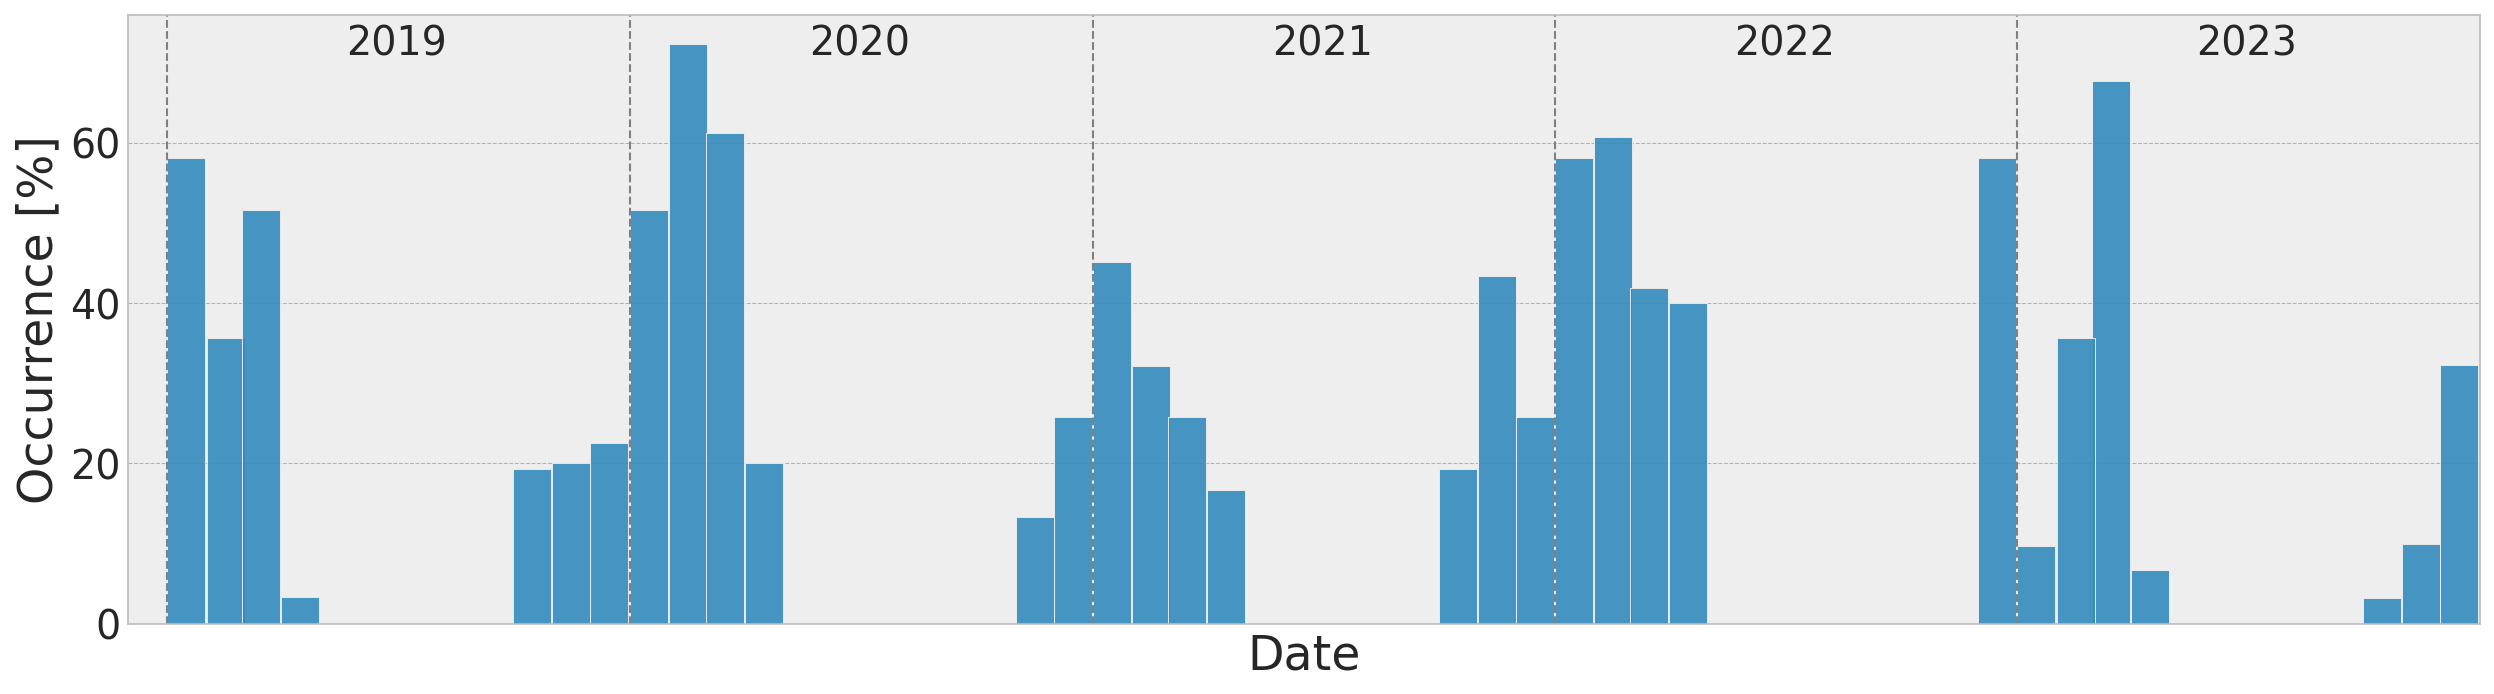

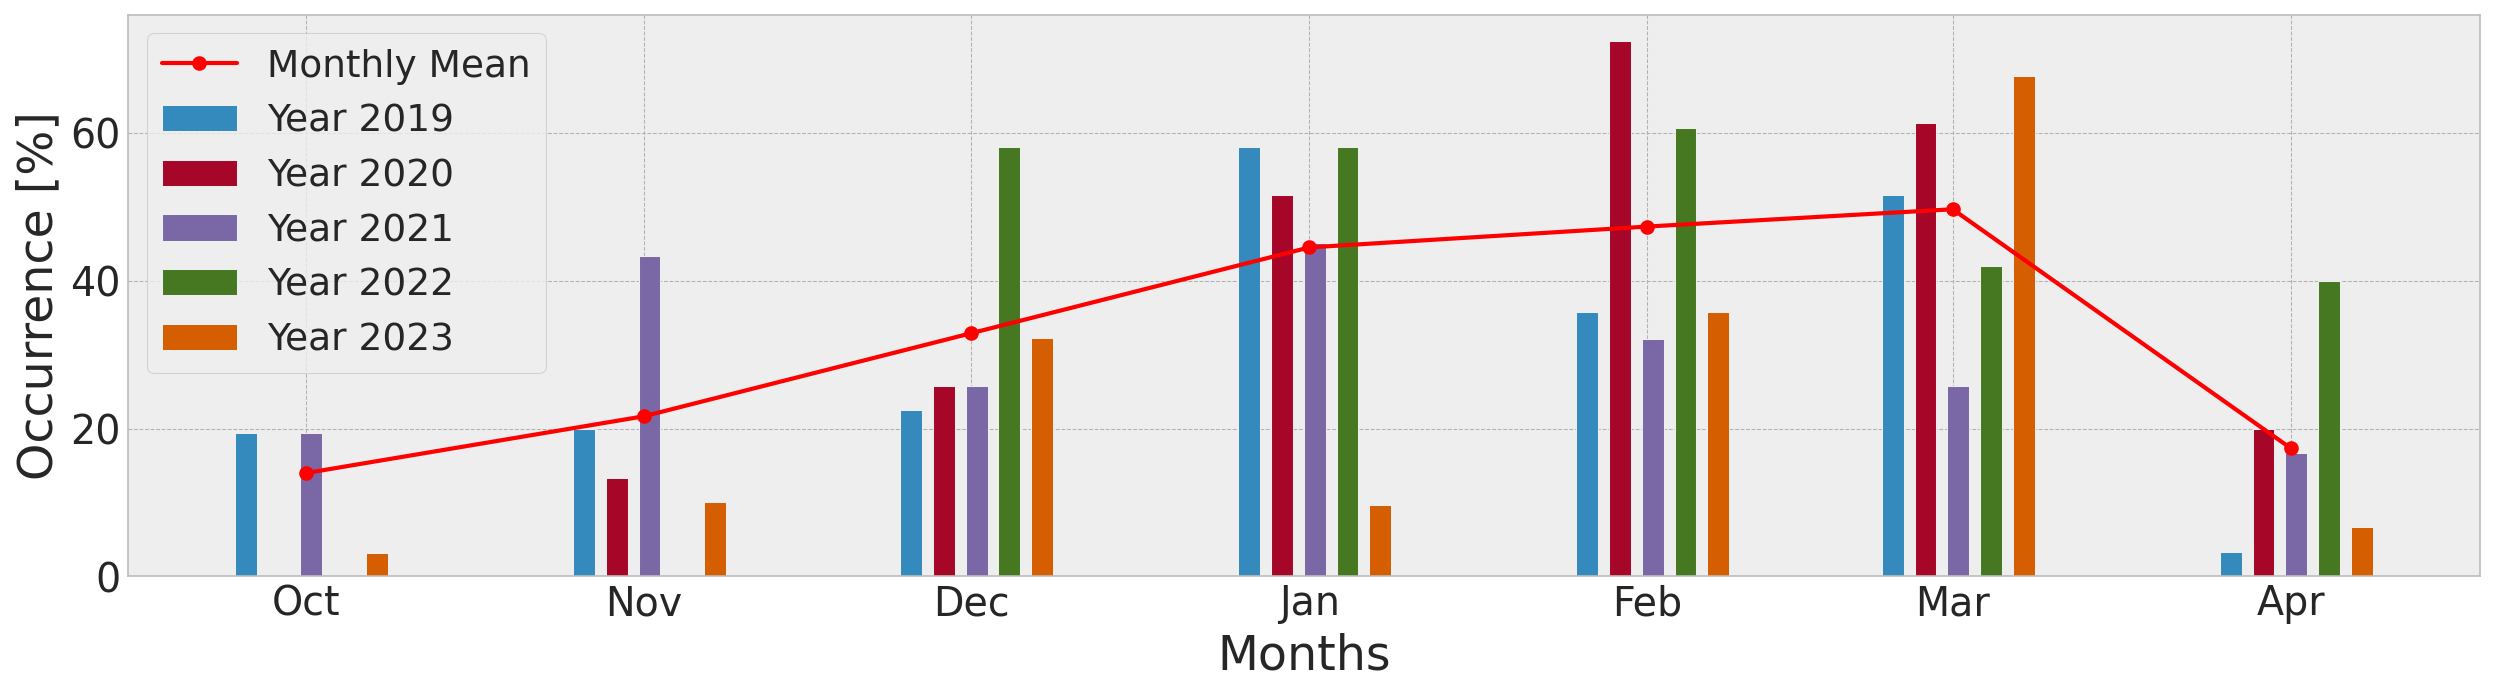

35.57277927856349


In [26]:
from collections import defaultdict
from calendar import monthrange
matplotlib.rcParams.update({'font.size': 19})

# Flatten the list of dates across all indices
all_dates_fram = [str(date) for dates in dates_counted_fram.values() for date in dates]  # assuming dates are integers

# Create a dictionary to hold sets of unique days keyed by year-month
unique_days_per_month = defaultdict(set)

# Populate the dictionary with unique days
for date in all_dates_fram:
    year_month = date[:6]  # 'YYYYMM'
    unique_days_per_month[year_month].add(date[-2:])  # Add only the 'DD' part of 'YYYYMMDD'

# Now calculate and print the percentage for each year-month
perc_list = []
for year_month, days in unique_days_per_month.items():
    year, month = int(year_month[:4]), int(year_month[4:6])
    unique_days_count = len(days)
    total_days_in_month = monthrange(year, month)[1]  # Get the total number of days in this month of this year
    percentage_of_days = (unique_days_count / total_days_in_month) * 100
    perc_list.append(percentage_of_days)
    #print(f"{year_month}: {unique_days_count}/{total_days_in_month} days ({percentage_of_days:.2f}%)")

# Using a list comprehension to create datetime objects from keys
all_dates = [datetime.datetime(int(date[:4]), int(date[4:6]), 1) for date in unique_days_per_month.keys()]
plt.figure(figsize=[17, 5], dpi=150)

plt.bar(all_dates, perc_list, width=30, align="edge", alpha=0.9)
# plt.title("CAO occurrence in the Fram Strait")
plt.ylabel("Occurrence [%]")
plt.xlim([datetime.datetime(2018, 12, 1), datetime.datetime(2024, 1, 1)])

# Iterate over the range of years and add vertical lines and text
for year in range(2018, 2024):
    # Add a vertical line at the start of each year
    plt.axvline(datetime.datetime(year, 1, 1), color='gray', linestyle='--', linewidth=1)
for year in range(2019, 2024):

    # Add the year as text just below the top of the figure
    plt.text(datetime.datetime(year, 7, 1), max(perc_list), str(year),
             horizontalalignment='center', verticalalignment='center')
plt.xticks([]) 
plt.xlabel("Date")
plt.tight_layout()


plt.savefig(save_folder + f"hist_fram_2019-2023_cao_months_thr{cao_threshold}_pthr{patch_threshold}.jpg")


plt.figure(figsize=[17, 5], dpi=150)

bar_width = 2  # Width of individual bars in the plot

years = sorted(set(int(date[:4]) for date in unique_days_per_month.keys()))

# Adjust the loop to handle the year shift for months 10, 11, and 12
for idx, year in enumerate(years):
    bar_positions = []
    perc_for_year = []
    for date in unique_days_per_month.keys():
        # Identify the year and the month
        int_year, int_month = int(date[:4]), int(date[4:6])
        
        if int_year == year:
            # Adjust the month position for each bar based on the year index
            if int_month >= 10:
                adjusted_date = datetime.datetime(2000, int_month, 1) +  datetime.timedelta(days=15)
            else:
                adjusted_date = datetime.datetime(2001, int_month, 1) +  datetime.timedelta(days=15)
            offset = datetime.timedelta(days=bar_width * 1.5 * (idx - len(years) / 2))
            bar_positions.append(adjusted_date + offset)
            # Find the percentage for this month and add it to the list
            perc_index = all_dates.index(datetime.datetime(int_year, int_month, 1))
            perc_for_year.append(perc_list[perc_index])
                
            
    plt.bar(bar_positions, perc_for_year, width=bar_width, align='edge', label=f"Year {year}")

monthly_means = defaultdict(lambda: [])
for year_month, days in unique_days_per_month.items():
    year, month = int(year_month[:4]), int(year_month[4:6])
    monthly_means[month].append(len(days) / monthrange(year, month)[1] * 100)

monthly_mean_percentages = [np.mean(monthly_means[month]) for month in [10,11,12,1,2,3,4]]

monthly_mean_dates = [datetime.datetime(2000, month, 15) for month in [10,11,12]] + [datetime.datetime(2001, month, 15) for month in [1,2,3,4]]

plt.plot(monthly_mean_dates, monthly_mean_percentages, color='r', marker='o', linestyle='-', linewidth=2, markersize=6, label="Monthly Mean")

# Formatting the plot
# plt.title("CAO Occurrence in the Fram Strait by Year with Monthly Averages")
plt.xlabel("Month")
plt.ylabel("Occurrence [%]")
plt.legend(loc="upper left", fontsize=18)

# Configure x-axis with month names
import datetime

# for the year 2000 and 2001
monthly_mean_dates = [datetime.datetime(2000, month, 15) for month in range(10, 13)] + [datetime.datetime(2001, month, 15) for month in range(1, 5)]


plt.xlabel('Months')
plt.ylabel("Occurrence [%]")
plt.xticks(monthly_mean_dates, ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])  # Set the x-ticks to display month names
plt.tight_layout()

plt.savefig(save_folder + f"hist_monthly_fram_2019-2023_cao_months_thr{cao_threshold}_pthr{patch_threshold}.jpg")

plt.show()
print(np.mean(monthly_mean_percentages[1:]))


In [21]:
save_folder


'/uio/hume/student-u37/fslippe/master_project/figures/hist_maps/thr5/'

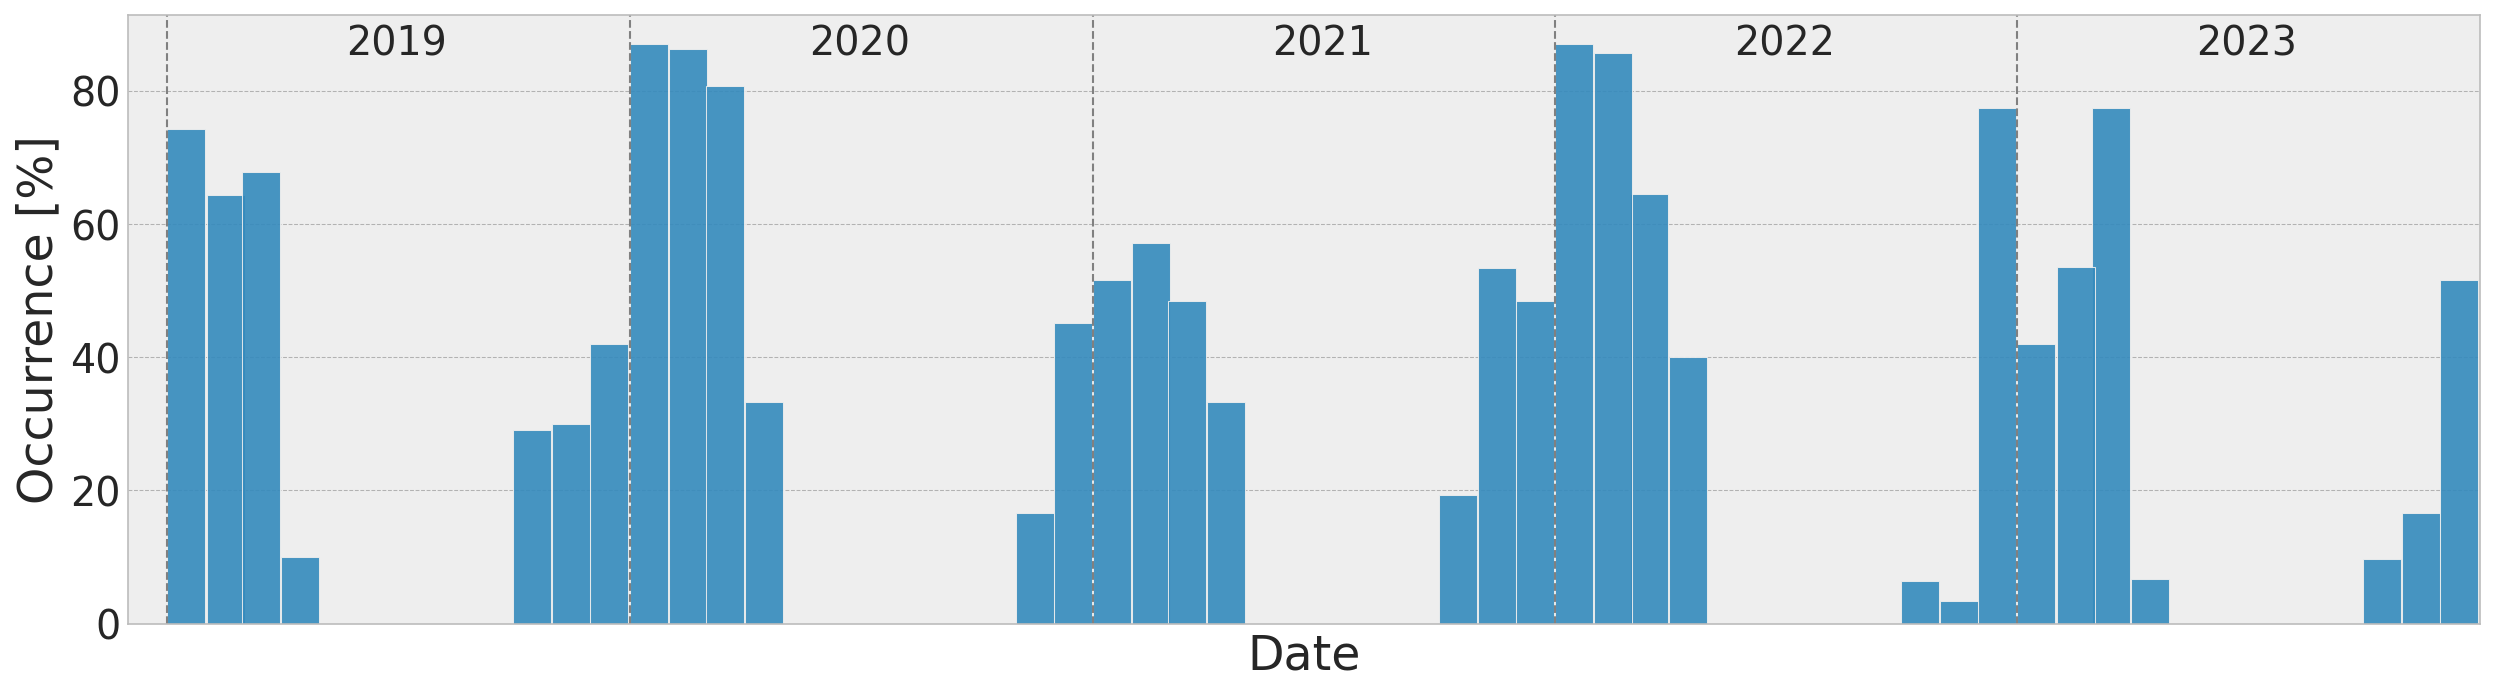

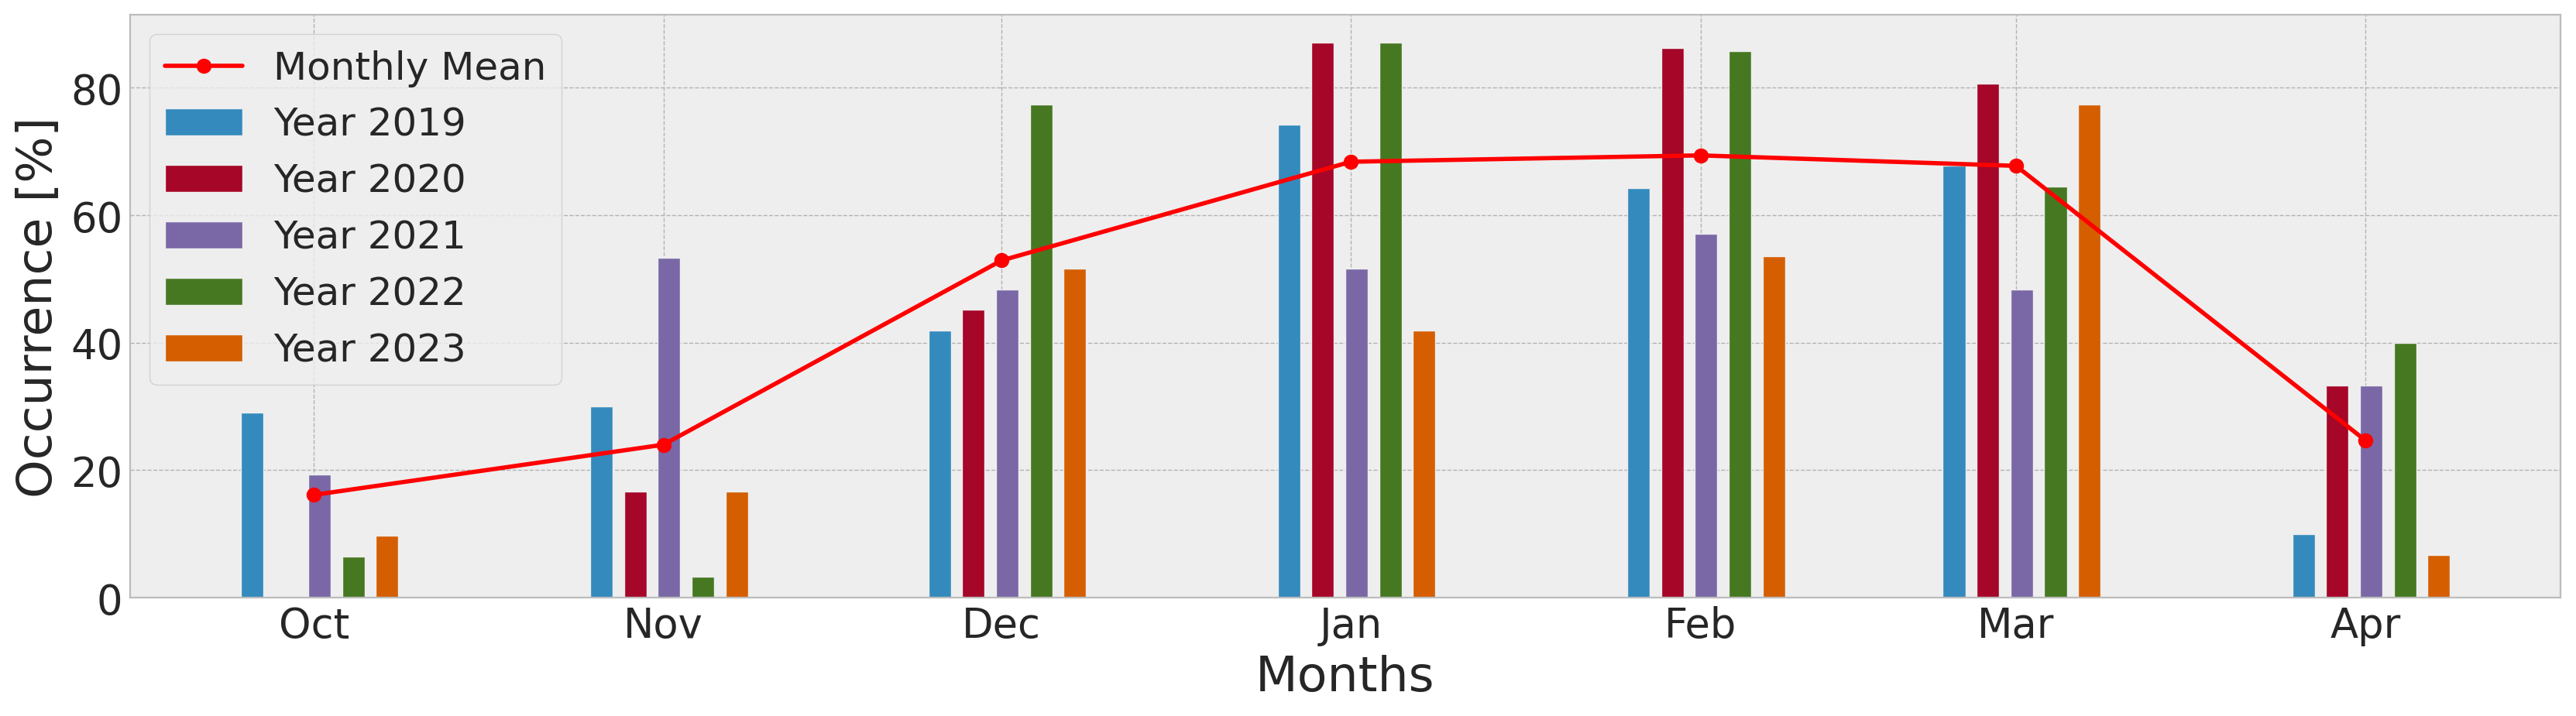

In [27]:
from collections import defaultdict
from calendar import monthrange
matplotlib.rcParams.update({'font.size': 19})

# Flatten the list of dates across all indices
all_dates = [str(date) for dates in dates_counted.values() for date in dates]  # assuming dates are integers

# Create a dictionary to hold sets of unique days keyed by year-month
unique_days_per_month = defaultdict(set)

# Populate the dictionary with unique days
for date in all_dates:
    year_month = date[:6]  # 'YYYYMM'
    unique_days_per_month[year_month].add(date[-2:])  # Add only the 'DD' part of 'YYYYMMDD'

# Now calculate and print the percentage for each year-month
perc_list = []
for year_month, days in unique_days_per_month.items():
    year, month = int(year_month[:4]), int(year_month[4:6])
    unique_days_count = len(days)
    total_days_in_month = monthrange(year, month)[1]  # Get the total number of days in this month of this year
    percentage_of_days = (unique_days_count / total_days_in_month) * 100
    perc_list.append(percentage_of_days)
    #print(f"{year_month}: {unique_days_count}/{total_days_in_month} days ({percentage_of_days:.2f}%)")

# Using a list comprehension to create datetime objects from keys
all_dates = [datetime.datetime(int(date[:4]), int(date[4:6]), 1) for date in unique_days_per_month.keys()]

plt.figure(figsize=[17, 5], dpi=150)

plt.bar(all_dates, perc_list, width=30, align="edge", alpha=0.9)
# plt.title("CAO occurrence in the whole domain")
plt.ylabel("Occurrence [%]")
plt.xlim([datetime.datetime(2018, 12, 1), datetime.datetime(2024, 1, 1)])

# Iterate over the range of years and add vertical lines and text
for year in range(2018, 2024):
    # Add a vertical line at the start of each year
    plt.axvline(datetime.datetime(year, 1, 1), color='gray', linestyle='--', linewidth=1)
for year in range(2019, 2024):
    plt.text(datetime.datetime(year, 7, 1), max(perc_list), str(year),
             horizontalalignment='center', verticalalignment='center')
plt.xticks([]) 
plt.xlabel("Date")
plt.tight_layout()

plt.savefig(save_folder + f"hist_2019-2023_cao_months_thr{cao_threshold}_pthr{patch_threshold}.jpg")
plt.show()



plt.figure(figsize=[17, 5], dpi=200)

bar_width = 2  # Width of individual bars in the plot

years = sorted(set(int(date[:4]) for date in unique_days_per_month.keys()))

# Adjust the loop to handle the year shift for months 10, 11, and 12
for idx, year in enumerate(years):
    bar_positions = []
    perc_for_year = []
    for date in unique_days_per_month.keys():
        # Identify the year and the month
        int_year, int_month = int(date[:4]), int(date[4:6])
        
        if int_year == year:
            # Adjust the month position for each bar based on the year index
            if int_month >= 10:
                adjusted_date = datetime.datetime(2000, int_month, 1) +  datetime.timedelta(days=15)
            else:
                adjusted_date = datetime.datetime(2001, int_month, 1) +  datetime.timedelta(days=15)
            offset = datetime.timedelta(days=bar_width * 1.5 * (idx - len(years) / 2))
            bar_positions.append(adjusted_date + offset)
            # Find the percentage for this month and add it to the list
            perc_index = all_dates.index(datetime.datetime(int_year, int_month, 1))
            perc_for_year.append(perc_list[perc_index])
                
            
    plt.bar(bar_positions, perc_for_year, width=bar_width, align='edge', label=f"Year {year}")

monthly_means = defaultdict(lambda: [])
for year_month, days in unique_days_per_month.items():
    year, month = int(year_month[:4]), int(year_month[4:6])
    monthly_means[month].append(len(days) / monthrange(year, month)[1] * 100)

monthly_mean_percentages = [np.mean(monthly_means[month]) for month in [10,11,12,1,2,3,4]]

monthly_mean_dates = [datetime.datetime(2000, month, 15) for month in [10,11,12]] + [datetime.datetime(2001, month, 15) for month in [1,2,3,4]]

plt.plot(monthly_mean_dates, monthly_mean_percentages, color='r', marker='o', linestyle='-', linewidth=2, markersize=6, label="Monthly Mean")

# Formatting the plot
# plt.title("CAO Occurrence in the the whole domain by Year with Monthly Averages")
plt.xlabel("Month")
plt.ylabel("Occurrence [%]")
plt.legend(loc="upper left", fontsize=18)

monthly_mean_dates = [datetime.datetime(2000, month, 15) for month in range(10, 13)] + [datetime.datetime(2001, month, 15) for month in range(1, 5)]


plt.xlabel('Months')
plt.ylabel('Occurrence [%]')
plt.xticks(monthly_mean_dates, ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])  # Set the x-ticks to display month names
plt.tight_layout()
plt.savefig(save_folder + f"hist_monthly_2019-2023_cao_months_thr{cao_threshold}_pthr{patch_threshold}.jpg")
plt.show()

